# Stochastic Simulations - group project

## Project 4 : Variance reduction in Monte Carlo integration via function approximation

Francesca Bettinelli \
Marianna Dell'Otto \
Sophie Lequeu

In [1]:
from question2 import *
from question4 import *
from question5 import *
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import time

### Question 1
Properties of $I_{MCLS}$ and $I_{MCLS}'$ estimators. \
See LaTeX report.

### Question 2
Estimating integral :
$$I_0 = \int_0^1 \frac{1}{25 x^2+1} dx$$
#### a) Crude Monte Carlo estimator
We begin by estimating the integral *$I$* using a crude Monte Carlo estimator *$I_{MC}$*.

In [2]:
# exact value of the integral (reference)
ref_value = (1/5) * np.arctan(5)

# crude Monte Carlo estimators
N = 100
nb_samples = np.logspace(np.log10(10), np.log10(10000), num=N, dtype=int) # evenly spaced values on a logarithmic scale

CMC_estims = np.zeros(N)
CMC_CI = np.zeros((N,2))
CMC_CI2 = np.zeros((N,2))
alpha=0.05
for M in range(N):
    unif_samps = np.random.uniform(0, 1, nb_samples[M])
    CMC_estims[M], CMC_CI[M] = crude_MC(unif_samps, f, alpha)
    CMC_CI2[M]= CI_CMC(unif_samps, f, 0, CMC_estims[M], alpha)
    

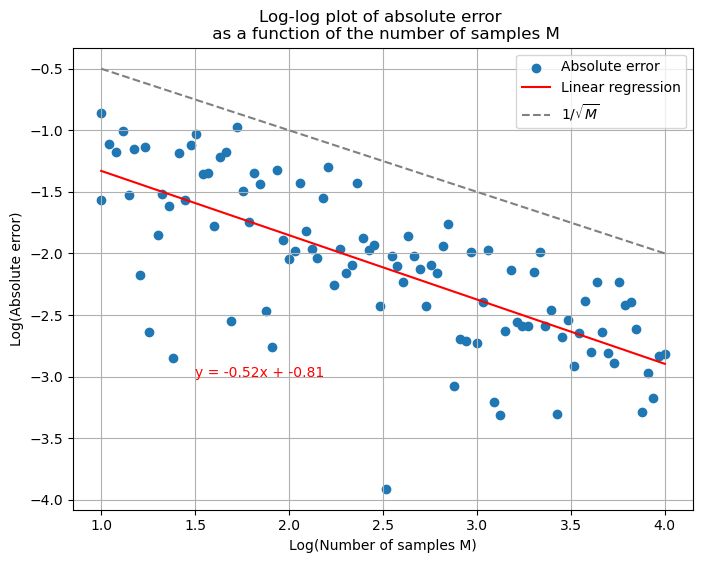

In [3]:
# Plot log-log graph to see order of the error
# Done here on 1 experiment for each M (number of samples)
# We note that this is quite dependent on the realisations of experiments for each M
loglog_graph(nb_samples, CMC_estims, ref_value)

# Cell below allows to perform a few experiments for each M and to plot the average observed error

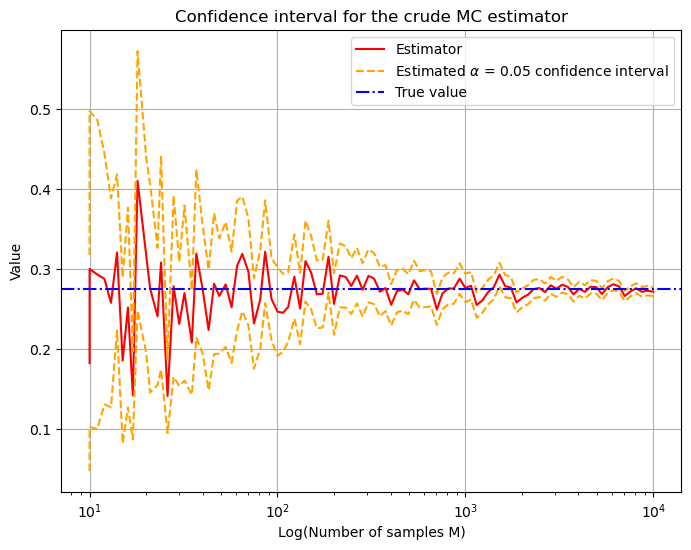

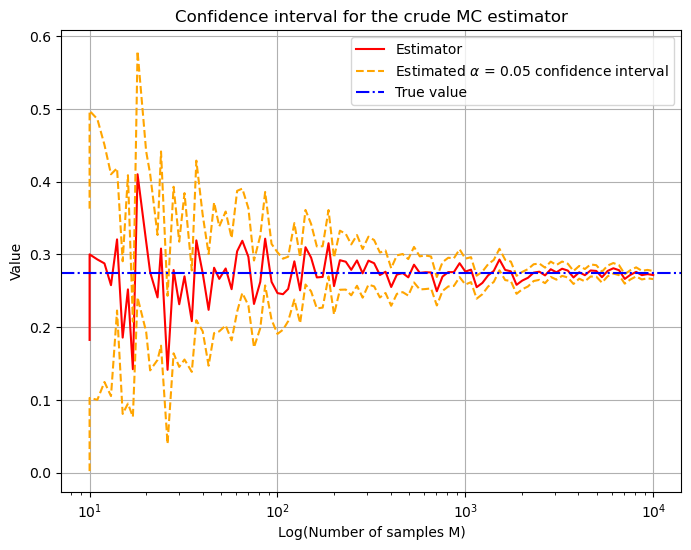

In [3]:
# Confidence intervals around each CMC estimator
#print(CMC_CI[0])
# Plot of the confidence intervals
# comparison between the one calculated by np.var(f) and the one with LS
plot_CI(nb_samples, CMC_estims, CMC_CI, ref_value, alpha)
plot_CI(nb_samples, CMC_estims, CMC_CI2, ref_value, alpha)

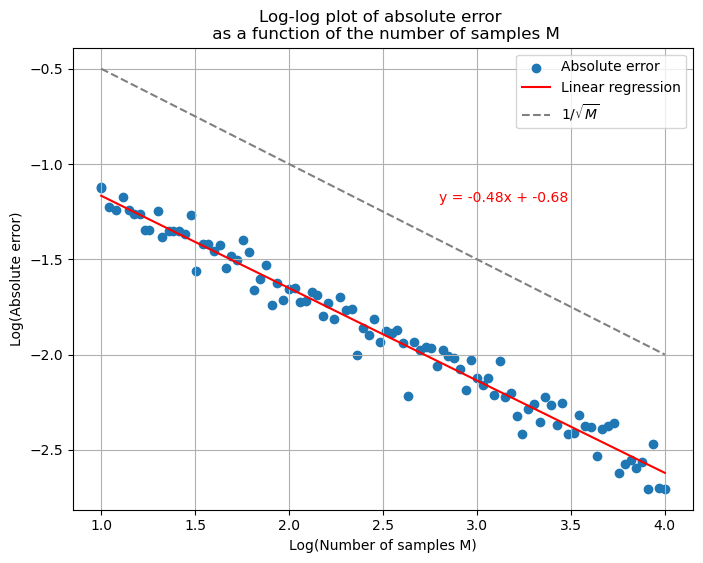

In [5]:
# Averaging the absolute error, i.e. doing 'averaging' experiments for each value of M (number of samples), and 
# returning the average absolute error over these experiments.
averaging = 20
CMC_estims_av = np.zeros((N, averaging))
for M in range(N):
    CMC_estims_M = np.zeros(averaging)
    for i in range(averaging) :
        unif_samps = np.random.uniform(0, 1, nb_samples[M])
        CMC_estims_M[i], CI = crude_MC(unif_samps, f, alpha)
    CMC_estims_av[M][:] = CMC_estims_M

loglog_average_error_graph(nb_samples, CMC_estims_av, ref_value)

Plotting the error of the crude Monte Carlo estimator for different values of M (in log-log scale), we observe that it can be approximated by a straight line with slope $\approx 0.5$. We conclude that the error decreases approximately as the square-root of the number of samples M. This is indeed what was expected from a crude Monte Carlo estimator, since it is unbiaised, with variance in $\mathcal{O}(M)$, thus confidence interval in $\mathcal{O}(\sqrt M)$ (from the CLT).

#### b) MCLS
The aim of this second part is to implement the MCLS estimators *$I_{MCLS}$* using an expansion of the Legendre polynomials up to degree n.
We will consider the same values of $M$ (numbers of samples) as in *(a)*, and try different values of $n$ : \
    $n = 10, 20, 30, 50$, \
    $n = \lceil \sqrt M \rceil$, \
    $n = \lceil \frac{M}{2} \rceil$.

In [4]:
ref_value = (1/5) * np.arctan(5)
N = 200
nb_samples = np.logspace(np.log10(10), np.log10(2000), num=N, dtype=int) # evenly spaced values on a logarithmic scale
alpha= 0.05

trials_n = [5, 10, 20, 30, -1, -2]

nb_trials_n = len(trials_n)

# MCLS estimators
MCLS_estims = [-1 * np.ones(N) for _ in range(nb_trials_n)]
MCLS_prime_estims = [-1 * np.ones(N) for _ in range(nb_trials_n)]

# CI
MCLS_CI = [-1 * np.ones((N, 2)) for _ in range(nb_trials_n)]
MCLS_CIn = [-1 * np.ones((N, 2)) for _ in range(nb_trials_n)]

# condition number of the Vandermonde matrix
MCLS_cond = [-1 * np.ones(N) for _ in range(nb_trials_n)]
MCLS_prime_cond = [-1 * np.ones(N) for _ in range(nb_trials_n)]

for M in range(N):
    for i in range(nb_trials_n):
        n = trials_n[i]


        if n == -1:
            n = np.ceil(np.sqrt(nb_samples[M])).astype(int)
            if nb_samples[M] > 5000: # too computationally expensive
                break
        if n == -2:
            n = np.ceil((nb_samples[M])/2).astype(int)
            if nb_samples[M] > 5000: # too computationally expensive
                break

        #if n < nb_samples[M]:
        unif_samps = np.random.uniform(0, 1, nb_samples[M])
        MCLS_estims[i][M], MCLS_cond[i][M]= MCLS(unif_samps, f, n)
        MCLS_CI[i][M] = CI_MCLS(unif_samps, f, n, MCLS_estims[i][M], alpha)
        MCLS_CIn[i][M] = CI_MCLSn(unif_samps, f, n, MCLS_estims[i][M], alpha) # variance calculated with N-n
        MCLS_prime_estims[i][M], MCLS_prime_cond[i][M] = MCLS_prime(unif_samps, f, n)

C:\Users\Marianna\OneDrive - Politecnico di Milano\Desktop\Doppia laurea\EPFL\2023_2024_1\Stochastic simulation\stoch_project\Stochastic-simulations-project\question2.py:426: RuntimeWarning: divide by zero encountered in scalar divide
  CI = estim + np.array([-1, 1]) * quantile * np.sqrt(np.sum((f(samples) - np.polynomial.legendre.legval(samples2, c))**2) /len(samples)/ (len(samples)-n))
C:\Users\Marianna\OneDrive - Politecnico di Milano\Desktop\Doppia laurea\EPFL\2023_2024_1\Stochastic simulation\stoch_project\Stochastic-simulations-project\question2.py:426: RuntimeWarning: invalid value encountered in sqrt
  CI = estim + np.array([-1, 1]) * quantile * np.sqrt(np.sum((f(samples) - np.polynomial.legendre.legval(samples2, c))**2) /len(samples)/ (len(samples)-n))


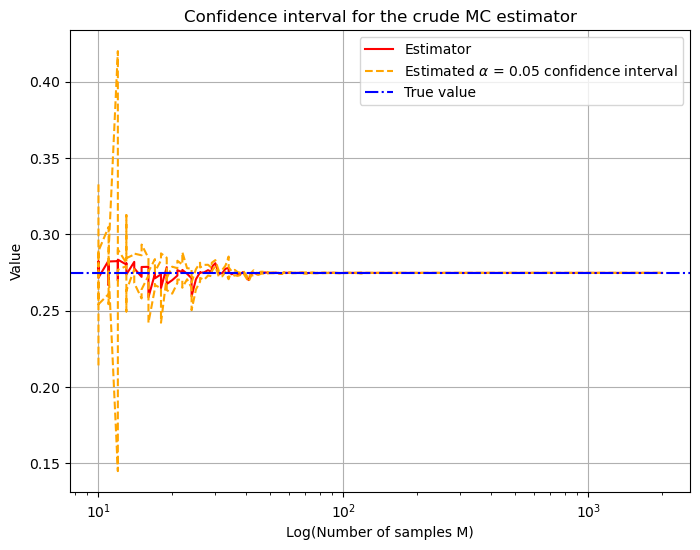

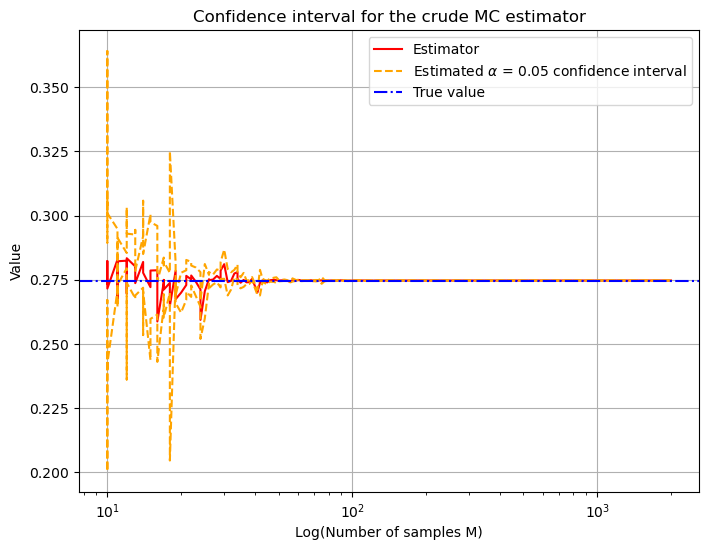

In [9]:
i=4
cut=0
# where: i=0 -> n_samples=5
# i=1 -> n_samples=10
# i=2 -> n_samples=20
# i=3 -> n_samples=30
# i=4 -> n_samples=ceil(sqrt(n_samples))
# i=5 -> n_samples=ceil(n_samples/2)
plot_CI(nb_samples[cut:], MCLS_estims[i][cut:], MCLS_CI[i][cut:], ref_value, alpha)
plot_CI(nb_samples[cut:], MCLS_estims[i][cut:], MCLS_CIn[i][cut:], ref_value, alpha)
#print(MCLS_CIn)
#plot_CI(nb_samples, MCLS_estims[i], MCLS_CI[i], ref_value, alpha)

In [46]:
ref_value = (1/5) * np.arctan(5)
# comparison between CMC and MCLS estimator
N = 200
nb_samples = np.logspace(np.log10(10), np.log10(1000), num=N, dtype=int) # evenly spaced values on a logarithmic scale
alpha= 0.05

trials_n = [30]

nb_trials_n = len(trials_n)

# MCLS estimators
MCLS_estims = [-1 * np.ones(N) for _ in range(nb_trials_n)]
MCLS_prime_estims = [-1 * np.ones(N) for _ in range(nb_trials_n)]

# CI
MCLS_CI = [-1 * np.ones((N, 2)) for _ in range(nb_trials_n)]

# condition number of the Vandermonde matrix
MCLS_cond = [-1 * np.ones(N) for _ in range(nb_trials_n)]
MCLS_prime_cond = [-1 * np.ones(N) for _ in range(nb_trials_n)]
CMC_estims = [-1 * np.ones(N) for _ in range(nb_trials_n)]
CMC_CI = [-1 * np.ones((N, 2)) for _ in range(nb_trials_n)]

for M in range(N):
    for i in range(nb_trials_n):
        n = trials_n[i]
        if n == -1:
            n = np.ceil(np.sqrt(nb_samples[M])).astype(int)
            if nb_samples[M] > 5000: # too computationally expensive
                break
        if n == -2:
            n = np.ceil((nb_samples[M])/2).astype(int)
            if nb_samples[M] > 5000: # too computationally expensive
                break
        unif_samps = np.random.uniform(0, 1, nb_samples[M])
        CMC_estims[i][M], CMC_CI[i][M] = crude_MC(unif_samps, f, alpha)
        unif_samps = np.random.uniform(0, 1, nb_samples[M])
        MCLS_estims[i][M], MCLS_cond[i][M]= MCLS(unif_samps, f, n)
        MCLS_CI[i][M] = CI_MCLS(unif_samps, f, n, MCLS_estims[i][M], alpha)

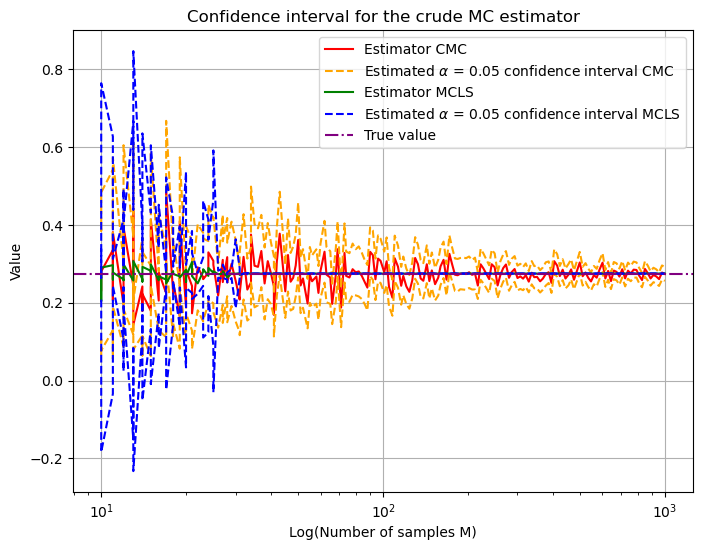

In [48]:
# plot of the confidence intervals of the two estimators
cut=1
plt.figure(figsize=(8, 6))
plt.plot(nb_samples[cut:], CMC_estims[0][cut:], label='Estimator CMC', color='red')
plt.plot(nb_samples[cut:], CMC_CI[0][cut:,0], linestyle='--', label='Estimated $ \\alpha $ = '+ str(alpha)+' confidence interval CMC', color='orange')
plt.plot(nb_samples[cut:], CMC_CI[0][cut:,1], linestyle='--', color='orange')
plt.plot(nb_samples[cut:], MCLS_estims[0][cut:], label='Estimator MCLS', color='green')
plt.plot(nb_samples[cut:], MCLS_CI[0][cut:, 0], linestyle='--', label='Estimated $ \\alpha $ = '+ str(alpha)+' confidence interval MCLS', color='blue')
plt.plot(nb_samples[cut:], MCLS_CI[0][cut:, 1], linestyle='--', color='blue')
plt.axhline(y=ref_value, color='purple', linestyle='-.', label='True value')

plt.xscale('log')  # Set x-axis to log scale
plt.xlabel('Log(Number of samples M)')
plt.ylabel('Value')
plt.title('Confidence interval for the crude MC estimator')
plt.legend()
plt.grid(True)
plt.show()

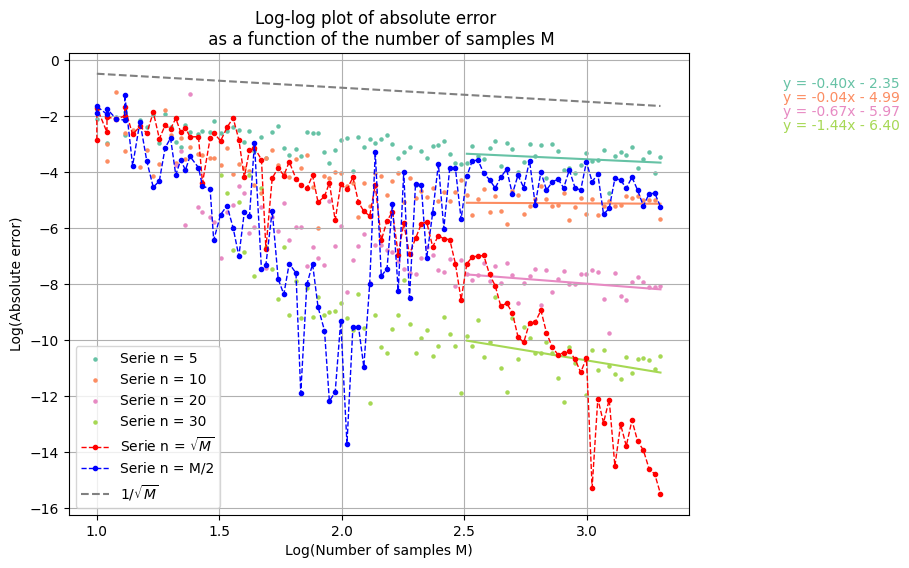

In [5]:
# plot log-log graph to see order of the error
multiple_loglog_graph(nb_samples, MCLS_estims, ref_value, trials_n)

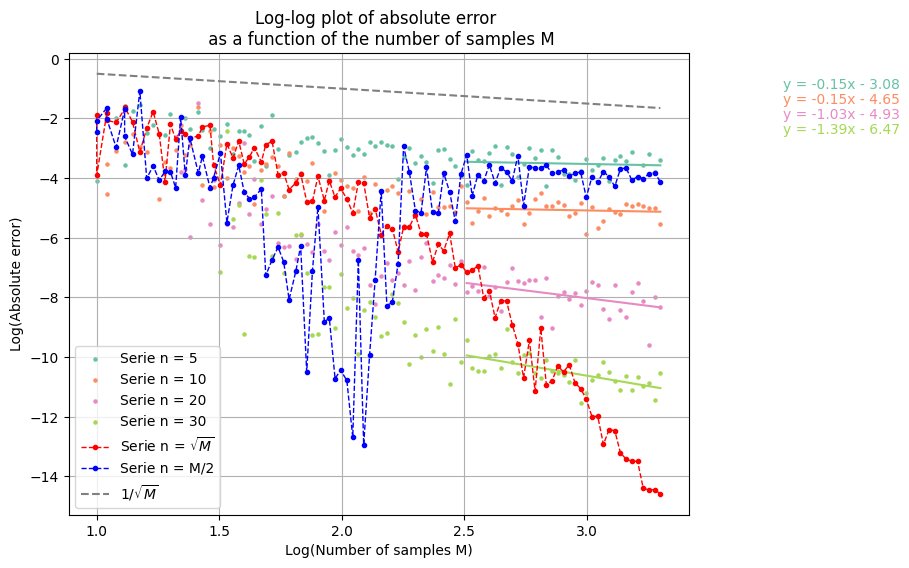

In [6]:
# plot log-log graph to see order of the error
multiple_loglog_graph(nb_samples, MCLS_prime_estims, ref_value, trials_n)

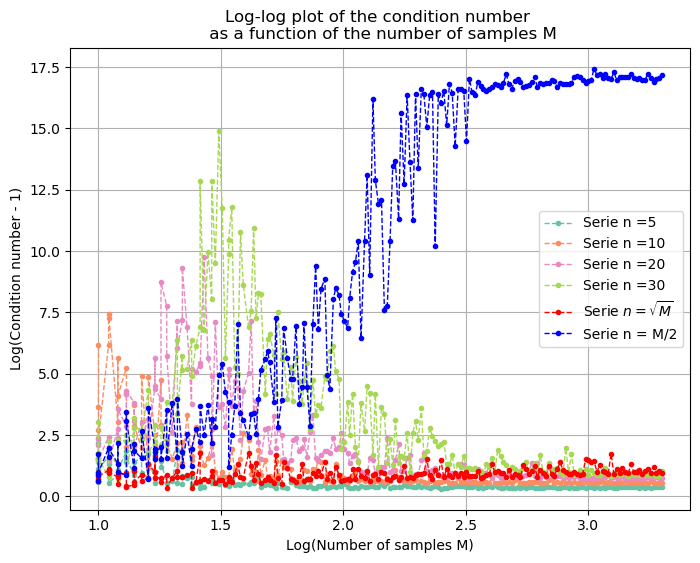

In [31]:
multiple_cond_loglog_graph(nb_samples, MCLS_cond, trials_n)

In [8]:
ref_value = (1/5) * np.arctan(5)
N = 100
nb_samples = np.logspace(np.log10(10), np.log10(2000), num=N, dtype=int) # evenly spaced values on a logarithmic scale

trials_n = [5, 10, 20, 30, -1, -2]
nb_trials_n = len(trials_n)

# MCLS estimators
MCLS_estims = [-1 * np.ones(N) for _ in range(nb_trials_n)]
MCLS_prime_estims = [-1 * np.ones(N) for _ in range(nb_trials_n)]

# condition number of the Vandermonde matrix
MCLS_cond = [-1 * np.ones(N) for _ in range(nb_trials_n)]
MCLS_prime_cond = [-1 * np.ones(N) for _ in range(nb_trials_n)]

for M in range(N):
    for i in range(nb_trials_n):
        n = trials_n[i]

        if n == -1:
            n = np.ceil(np.sqrt(nb_samples[M])).astype(int)
            if nb_samples[M] > 5000: # too computationally expensive
                break
        if n == -2:
            n = np.ceil((nb_samples[M])/2).astype(int)
            if nb_samples[M] > 5000: # too computationally expensive
                break

        if n < nb_samples[M]:
            unif_samps = np.random.uniform(0, 1, nb_samples[M])
            MCLS_estims[i][M], MCLS_cond[i][M] = MCLS_new(unif_samps, f, n) 
            MCLS_prime_estims[i][M], MCLS_prime_cond[i][M] = MCLS_prime_new(unif_samps, f, n)

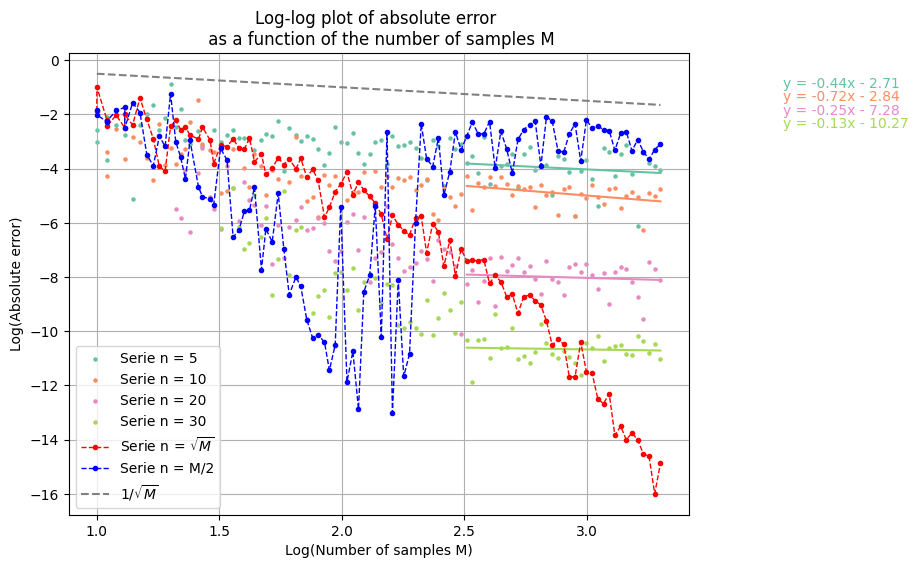

In [9]:
# plot log-log graph to see order of the error
multiple_loglog_graph(nb_samples, MCLS_estims, ref_value, trials_n)

From the plot, we can see that :
- Increasing the polynomial degree $n$ (with $n$ fixed w.r.t. the number of samples $M$) reduces the multiplicative constant. It reduces the error (for each number of samples M, the error is lower for n larger), but it doesn't change the order of convergence.
- If we set $n = \lceil \sqrt M \rceil$, the order of convergence significantly improves. The error is now decreasing faster than $\mathcal{O}(1 / \sqrt{M})$.
- If we set $n = \lceil \frac{M}{2} \rceil$, we distinguish : 
    - an initial phase affected by noise, where the error seems to decrease faster as well, 
    - and a second phase where the error seems to stabilize/decrease, again, as $\mathcal{O}(1 / \sqrt{M})$.

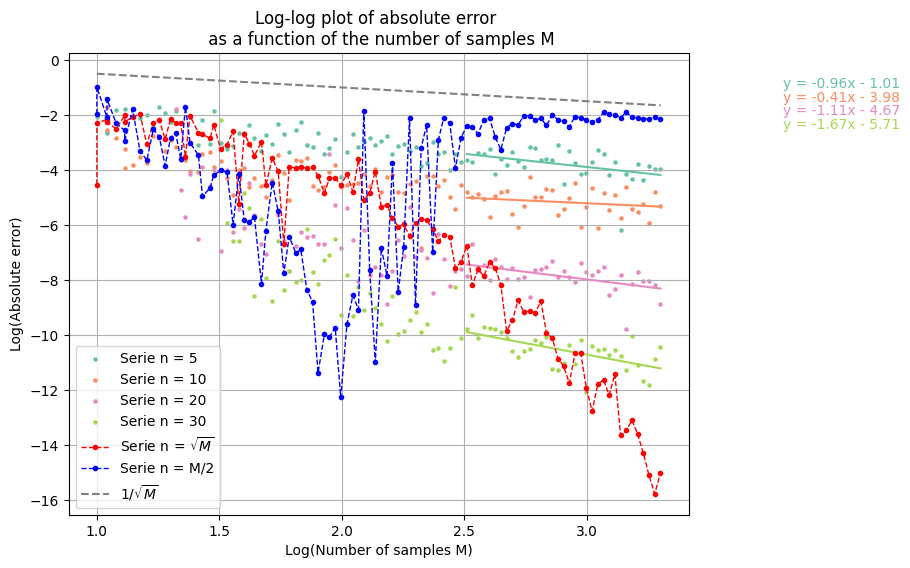

In [10]:
# plot log-log graph to see order of the error
multiple_loglog_graph(nb_samples, MCLS_prime_estims, ref_value, trials_n)

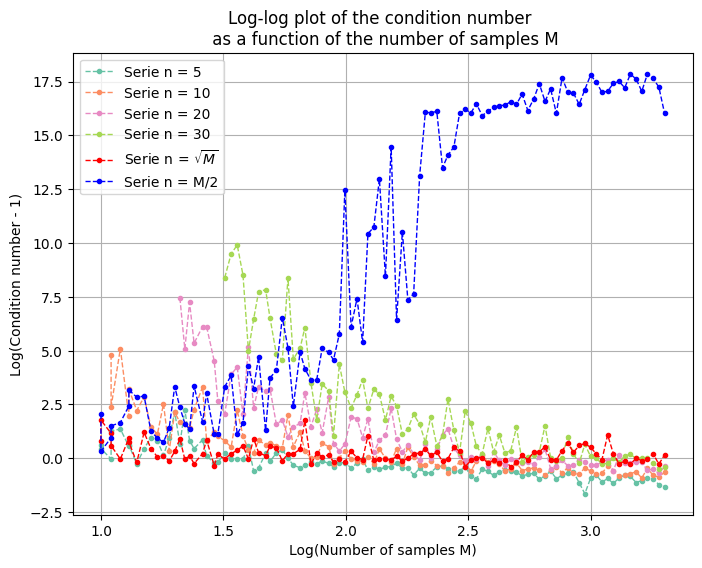

In [11]:
multiple_cond_loglog_graph(nb_samples, MCLS_cond, trials_n)

If we choose a value of $n$ too small w.r.t. $M$, the least squares problems becomes very ill-conditioned. If we set $n = \lceil \sqrt M \rceil$, the condition number of the Vandermonde matrix seems to be kept under control. In all these cases, the condition number tends to 1 as $M \to \infty$. Instead, if we set $n = \lceil \frac{M}{2} \rceil$, the condition number explodes as $M$ increases; this might be the reason behind the bad order of convergence of this estimator.

In [2]:
# comparison between different techniques to calculate the estimator (focus on the normalization)
ref_value = (1/5) * np.arctan(5)
N = 100
nb_samples = np.logspace(np.log10(10), np.log10(2000), num=N, dtype=int) # evenly spaced values on a logarithmic scale

trials_n = [5, 10, 20, 30, -1, -2]
nb_trials_n = len(trials_n)

# MCLS estimators
MCLS_estims1 = [-1 * np.ones(N) for _ in range(nb_trials_n)]
MCLS_estims2 = [-1 * np.ones(N) for _ in range(nb_trials_n)]
MCLS_estims3 = [-1 * np.ones(N) for _ in range(nb_trials_n)]
MCLS_estims4 = [-1 * np.ones(N) for _ in range(nb_trials_n)]
MCLS_estims5 = [-1 * np.ones(N) for _ in range(nb_trials_n)]
MCLS_estims6 = [-1 * np.ones(N) for _ in range(nb_trials_n)]

for M in range(N):
    for i in range(nb_trials_n):
        n = trials_n[i]

        if n == -1:
            n = np.ceil(np.sqrt(nb_samples[M])).astype(int)
            if nb_samples[M] > 5000: # too computationally expensive
                break
        if n == -2:
            n = np.ceil((nb_samples[M])/2).astype(int)
            if nb_samples[M] > 5000: # too computationally expensive
                break

        if n < nb_samples[M]:
            unif_samps = np.random.uniform(0, 1, nb_samples[M])
            samps_fit = np.random.uniform(0, 1, nb_samples[M])
            MCLS_estims1[i][M] = MCLS_V_V(unif_samps, samps_fit, f, n)
            MCLS_estims2[i][M] = MCLS_V_legval(unif_samps, samps_fit, f, n)
            MCLS_estims3[i][M] = MCLS_fit_V(unif_samps, samps_fit, f, n)
            MCLS_estims4[i][M] = MCLS_fit_legval(unif_samps, samps_fit, f, n)
            MCLS_estims5[i][M] = MCLS_nonorm(unif_samps, samps_fit, f, n)
            MCLS_estims6[i][M] = MCLS_new_nonorm(unif_samps, samps_fit, f, n)

/home/frabet/.local/lib/python3.10/site-packages/numpy/polynomial/legendre.py:1412: RankWarning: The fit may be poorly conditioned
  return pu._fit(legvander, x, y, deg, rcond, full, w)


In [12]:
# print the dimension of MCLS_estims2
print(len(MCLS_estims2), MCLS_estims2[0].shape)
# MCLS_estim[i][M]
# where: i=0 -> n_samples=5
# i=1 -> n_samples=10
# i=2 -> n_samples=20
# i=3 -> n_samples=30
# i=4 -> n_samples=ceil(sqrt(n_samples))
# i=5 -> n_samples=ceil(n_samples/2)
i = 3
j = 30
print(ref_value)
print(MCLS_estims1[i][j])
print(MCLS_estims2[i][j])
print(MCLS_estims3[i][j])
print(MCLS_estims4[i][j])
print(MCLS_estims5[i][j])
print(MCLS_estims6[i][j])

6 (100,)
0.2746801533890032
0.2746801203434787
0.2746801203434788
0.27468012034349254
0.2746801203434925
0.27468012034349587
0.2746801203434925


### Question 3
In this question, we propose an expression for $I_{MCLS}$ and $I_{MCLS}'$ generalized to the case of importance sampling. Samples $x^{(i)}$'s are now drawn from a distribution defined by the probability density function $g(x) = \frac{1}{w(x)}$.
We propose : 
$$I_{IS-MCLS} = \frac{\sum_{i=1}^M \left(f(x^{(i)}) - \sum_{j=0}^n c_j^{**} \phi_j(x^{(i)})\right) w(x^{(i)})}{\sum_{i=1}^M w(x^{(i)})} + c_0^{**}$$ 
and 
$$I_{IS-MCLS}' = c_0^{**}$$ 

where $\textbf{c**} = \text{argmin}_{\textbf{c} \in \mathbb{R}^{n+1}} \sum_{i=1}^M w(x^{(i)}) \left(f(x^{(i)}) - \sum_{j=0}^n c_j \phi_j (x^{(i)}) \right)^2$

as generalized estimators IS-MCLS and IS-MCLS'. \
In the LaTeX report, we verify that these verify the properties stated in Question 1 for classical $I_{IS-MCLS}$ and $I_{IS-MCLS}'$ estimators.

### Question 4
- Propose a method to sample from the density $h(x) := \frac{1}{w(x)}$ : \
We will be using the Acceptance-rejection method. This method is the one proposed in ref [2], page 6, where we only consider the case where function f has values in $R$ (and not $R^d$). We see 2 possible variations : 

    $\diamond$ Method 1 : \
We need a bound on the true propability density function. Knowing that every $\phi_j^2$ can be bounded by $4 e p_1^{\infty}(x)$, $h(x)$ can be bounded by the same quantity. We denote $g(x) = p_1^{\infty}(x) = \frac{1}{\pi \sqrt{x(1-x)}}$ (our bound, without the multiplicative constant).
    1.  Then we sample $Y$ from this bound $g(x)$. Since this bound has a nice expression, this can be done by Inverse transform method.
    We can easily check that the cdf associated to pdf $g(x)$ is : $G(x) = \frac{2}{\pi} \arcsin \sqrt{x}$, and the inverse function is : $G^{-1}(x) = \sin^2(\frac{\pi y}{2})$.
    2.  We sample $U$ from uniform on $[0, 1]$, independant of $Y$.
    3.  If $U \leq \frac{h(Y)}{Cg(Y)} $, set $X=Y$, otherwise return to step 1.

    $\diamond$ Method 2 : \
We note that the function we try to sample from is actually a mixture distribution (i.e., a convex sum of other distributions, with coefficients of the sum summing to 1). Knowing this, we'll use a composition method. Here we decompose our function into each $\phi_i^2$ $i=0,...n$, each of them with a coefficient $\frac{1}{n+1}$.
    1. Composition method : we sample to get a number between $0$ and $n$ to determine which $\phi_i^2$ to sample from.
    2. We sample $Y$ from the bound $g(x)$, $G(x) = \frac{2}{\pi} \arcsin \sqrt{x}$.
    3. We sample $U$ from uniform on $[0, 1]$, independent of $Y$.
    4. If $U \leq \frac{h(Y)}{Cg(Y)} $, set $X=Y$, otherwise return to step 2.

- Implement the MCLS estimators with importance sampling.
- Test on same number of samples as in Question 2. 


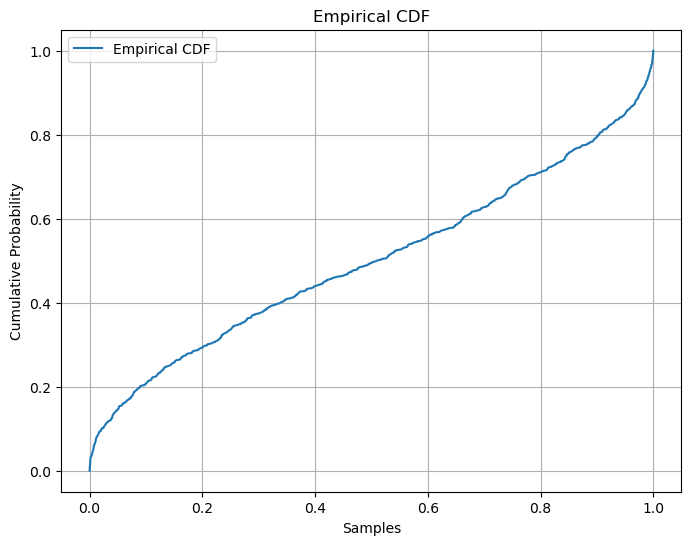

In [6]:
# 1. Test sampling from bound g, based on inverse transform method
Y_samples = sample_from_g(1000)
visualize_cdf_from_samples(Y_samples)

# Looks good, similar to expected distribution


### Expected pdf and cdf :

<div style="display: flex; flex-direction: row;">
    <img src="Arcsin_density.png" alt="Image 1" style="width: 50%; height: auto; margin-right: 10px;">
    <img src="Arcsin_cdf.png" alt="Image 2" style="width: 50%; height: auto;">
</div>

Source : Wikipedia, Arcsine distribution, https://en.wikipedia.org/wiki/Arcsine_distribution

#### Method 1 : AR on h(x) (the entire sum)

Acceptance rate :  0.09569377990430622


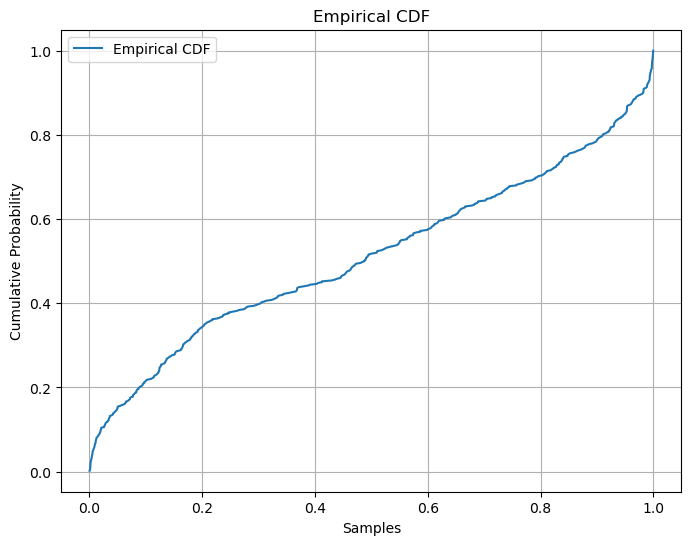

In [10]:
# 2. Test sampling from h = 1/w, done by acceptance-rejection method
H_samples = sample_from_h(500, 10000, 10)
visualize_cdf_from_samples(H_samples)

# Acceptance rate is low, about 9.2 percents
# if using bound C*g where g if a pdf (of integral 1) on function h (already normalized, so k=1), it makes sense though. See LaTeX report.

In [15]:
ref_value = (1/5) * np.arctan(5)
N = 10
nb_samples = np.logspace(np.log10(10), np.log10(1000), num=N, dtype=int) # evenly spaced values on a logarithmic scale

trials_n = [5, 10, 20, -1, -2, -3]
nb_trials_n = len(trials_n)

# MCLS estimators
ISMCLS_estims = [-1 * np.ones(N) for _ in range(nb_trials_n)]
ISMCLS_prime_estims = [-1 * np.ones(N) for _ in range(nb_trials_n)]

# condition number of the Vandermonde matrix
ISMCLS_cond = [-1 * np.ones(N) for _ in range(nb_trials_n)]
ISMCLS_prime_cond = [-1 * np.ones(N) for _ in range(nb_trials_n)]

for M in range(N):
    for i in range(nb_trials_n):
        n = trials_n[i]

        if n == -1:
            n = np.ceil(np.sqrt(nb_samples[M])).astype(int)
            if nb_samples[M] > 5000: # too computationally expensive
                break
        if n == -2:
            n = np.ceil((nb_samples[M])/2).astype(int)
            if nb_samples[M] > 5000: # too computationally expensive
                break
        if n == -3:
            n = nb_samples[M]*np.log(nb_samples[M]).astype(int)
            if nb_samples[M] > 5000: # too computationally expensive
                break

        if n < nb_samples[M]:
            unif_samps = np.random.uniform(0, 1, nb_samples[M])
            H_samples1 = sample_from_h(nb_samples[M], 1000000, 10)
            H_samples2 = sample_from_h(nb_samples[M], 1000000, 10)
            ISMCLS_estims[i][M], ISMCLS_cond[i][M] = IS_MCLS(H_samples1, H_samples2, f, n)

Acceptance rate :  0.1111111111111111
Acceptance rate :  0.046511627906976744
Acceptance rate :  0.07352941176470588
Acceptance rate :  0.10638297872340426
Acceptance rate :  0.06756756756756757
Acceptance rate :  0.09090909090909091
Acceptance rate :  0.11731843575418995
Acceptance rate :  0.08015267175572519
Acceptance rate :  0.14788732394366197
Acceptance rate :  0.0995260663507109
Acceptance rate :  0.0958904109589041
Acceptance rate :  0.12962962962962962
Acceptance rate :  0.08786610878661087
Acceptance rate :  0.09170305676855896
Acceptance rate :  0.10194174757281553
Acceptance rate :  0.08936170212765958
Acceptance rate :  0.10021786492374728
Acceptance rate :  0.10087719298245613
Acceptance rate :  0.10747663551401869
Acceptance rate :  0.06980273141122914
Acceptance rate :  0.08027923211169284
Acceptance rate :  0.08440366972477065
Acceptance rate :  0.07876712328767123
Acceptance rate :  0.077834179357022
Acceptance rate :  0.08534322820037106
Acceptance rate :  0.08333333

c:\Users\Lenovo\OneDrive\Documents\Master\EPFL\SS\Stochastic-simulations-project\question4.py:33: RuntimeWarning: divide by zero encountered in divide
  return 1/denominator


Acceptance rate :  0.09117896522476675
Acceptance rate :  0.10084427767354597
Acceptance rate :  0.0921165381319623
Acceptance rate :  0.0898078529657477
Acceptance rate :  0.0847457627118644
Acceptance rate :  0.08797054009819967
Acceptance rate :  0.08791208791208792
Acceptance rate :  0.09180846853977048
Acceptance rate :  0.08902532617037605
Acceptance rate :  0.08784551306323363
Acceptance rate :  0.0999784529196294
Acceptance rate :  0.08868501529051988
Acceptance rate :  0.0919175911251981
Acceptance rate :  0.09345417925478348
Acceptance rate :  0.09484873262469337
Acceptance rate :  0.08629347219639204
Acceptance rate :  0.0914662032379036
Acceptance rate :  0.09055510278004165
Acceptance rate :  0.09154155986818015
Acceptance rate :  0.0918189330639978
Acceptance rate :  0.09425959091337544
Acceptance rate :  0.09272997032640949
Acceptance rate :  0.08889679082585118
Acceptance rate :  0.09003331232556046
Acceptance rate :  0.09428625306430323
Acceptance rate :  0.08741258741

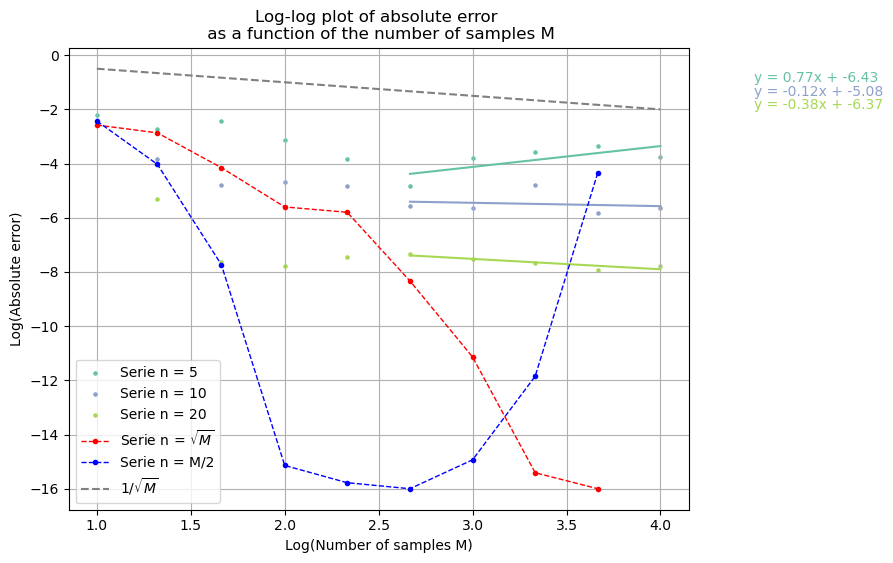

In [16]:
# plot log-log graph to see order of the error
multiple_loglog_graph(nb_samples, ISMCLS_estims, ref_value, trials_n)

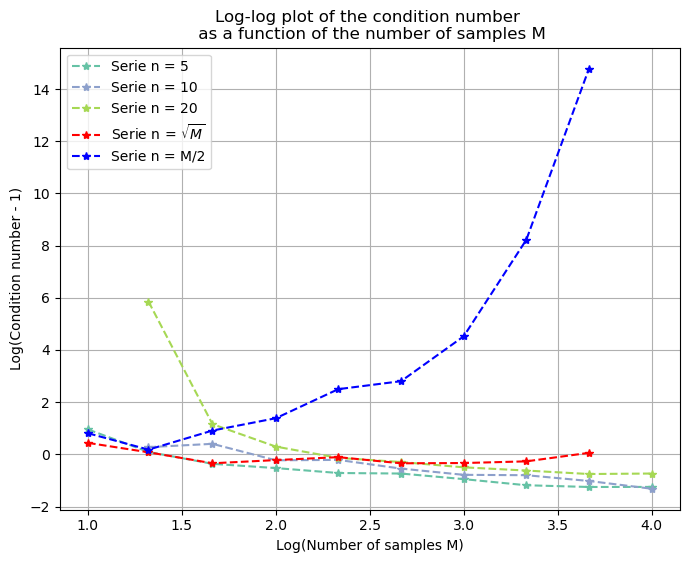

In [17]:
multiple_cond_loglog_graph(nb_samples, ISMCLS_cond, trials_n)

In [22]:
# Test cell
# Test weighted least squares
W = [1, 2] # square root of W
x = [0, 1]
f = [0, 10]
c, diagnostics = np.polynomial.legendre.Legendre.fit(x, f, 0, domain=[0, 1], full=True, w=W)
print(c)

# Test legendre polynomials
# c are the coefficients to put in front of the Legendre polynomials with domain [0, 1] and non-normalized. 
# (i.e, the coefficients c contain the necessary multiplicative constant)
x = [0, 1]
f = [0, 10]
c, diagnostics = np.polynomial.legendre.Legendre.fit(x, f, 1, domain=[0, 1], full=True, w=W)
print(c)


# Test dot product
a = [1, 2]
b = [1, 3]
print(np.dot(a, b))

8.0
5.0 + 5.0 P_1(x)
7


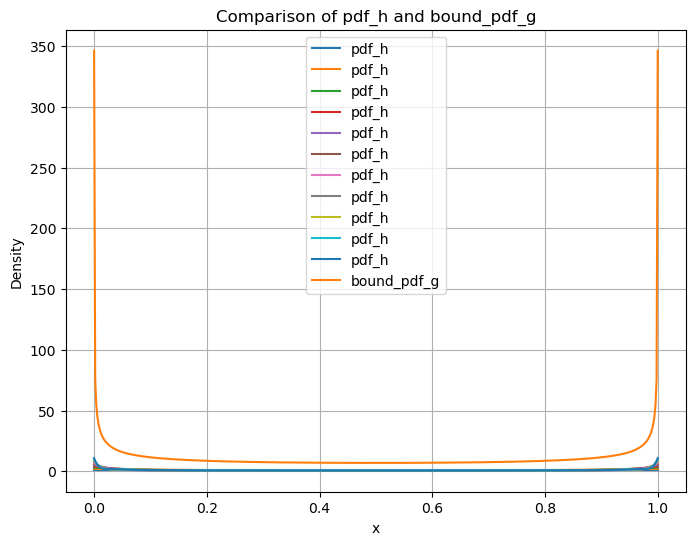

In [12]:
visualize_bound_g_on_h(10)

# bound seems way too loose, but we don't have anything better proven.

#### Method 2: composition method for a mixture density + AR method

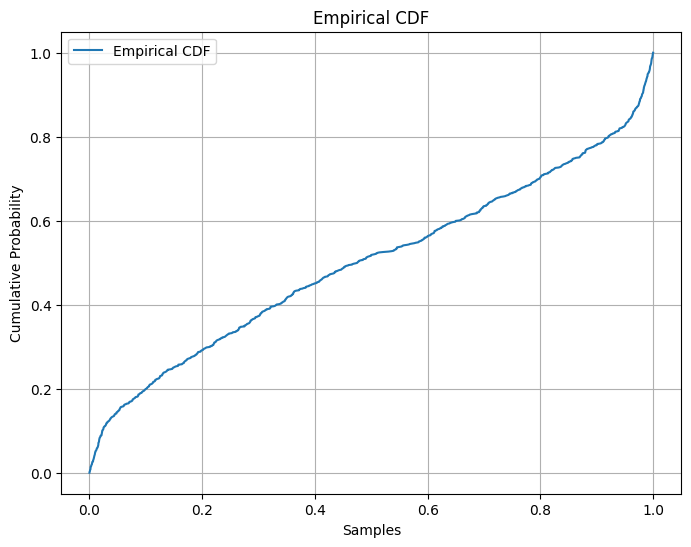

In [29]:
H_samples = sample_from_h_new(1000, 100, 5)
visualize_cdf_from_samples(H_samples)

In [ ]:
# Compare theoretical and empirical pfd

n = 5
x = np.linspace(0.01, 0.99, 10000)

# theoretical pdf
h_th = h(x, n)

# empirical pdf
samples = sample_from_h_new(100000, 1000, n)
hist, bin_edges = np.histogram(samples, bins=1000, range=(0, 1))
xx = (bin_edges[1:] + bin_edges[:1000]) / 2
area = np.trapz(hist, xx)
hist = hist / area

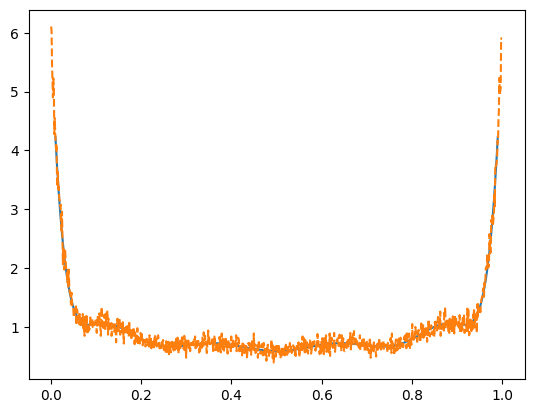

In [56]:
plt.plot(x, h_th)
plt.plot(xx, hist, '--')
plt.show()

True


<function matplotlib.pyplot.show(close=None, block=None)>

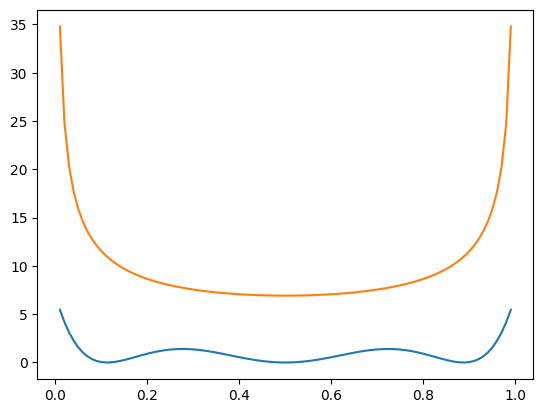

In [18]:
# Visual check for the bound

n = 3
C = 4 * np.e
x = np.linspace(0.01, 0.99, 100)
plt.plot(x, phi_squared(x, n))
plt.plot(x, C * g(x))
print(np.all(phi_squared(x, n) < C * g(x)))
plt.show

In [2]:
ref_value = (1/5) * np.arctan(5)
N = 100
nb_samples = np.logspace(np.log10(10), np.log10(2000), num=N, dtype=int) # evenly spaced values on a logarithmic scale

trials_n = [5, 10, 20, -1, -2, -3]
nb_trials_n = len(trials_n)

# MCLS estimators
IS_MCLS_estims = [-1 * np.ones(N) for _ in range(nb_trials_n)]
IS_MCLS_prime_estims = [-1 * np.ones(N) for _ in range(nb_trials_n)]

# condition number of the Vandermonde matrix
IS_MCLS_cond = [-1 * np.ones(N) for _ in range(nb_trials_n)]
IS_MCLS_prime_cond = [-1 * np.ones(N) for _ in range(nb_trials_n)]

tic = time.time()

for M in range(N):
    for i in range(nb_trials_n):

        if (M * nb_trials_n + i) % 10 == 0:
            print(f'Iteration {M * nb_trials_n + i} of {N * nb_trials_n}')
        
        n = trials_n[i]

        if n == -1:
            n = np.ceil(np.sqrt(nb_samples[M])).astype(int)
            if nb_samples[M] > 5000: # too computationally expensive
                break
        if n == -2:
            n = np.ceil((nb_samples[M])/2).astype(int)
            if nb_samples[M] > 5000: # too computationally expensive
                break
        
        if n == -3:
            n = np.rint(np.real(nb_samples[M]/scipy.special.lambertw(nb_samples[M]))).astype(int)
            if nb_samples[M] > 5000:
                break

        #if n < nb_samples[M]:
        h_samples = sample_from_h_new(nb_samples[M], 1000, n)
        IS_MCLS_estims[i][M], IS_MCLS_cond[i][M] = IS_MCLS_new(h_samples, f, n)
        IS_MCLS_prime_estims[i][M], IS_MCLS_prime_cond[i][M] = IS_MCLS_prime_new(h_samples, f, n)

toc = time.time()
print(f'Elapsed time: {toc - tic}s')

Iteration 0 of 600
Iteration 10 of 600
Iteration 20 of 600
Iteration 30 of 600
Iteration 40 of 600
Iteration 50 of 600
Iteration 60 of 600
Iteration 70 of 600
Iteration 80 of 600
Iteration 90 of 600
Iteration 100 of 600
Iteration 110 of 600
Iteration 120 of 600
Iteration 130 of 600
Iteration 140 of 600
Iteration 150 of 600
Iteration 160 of 600
Iteration 170 of 600
Iteration 180 of 600
Iteration 190 of 600
Iteration 200 of 600
Iteration 210 of 600
Iteration 220 of 600
Iteration 230 of 600
Iteration 240 of 600
Iteration 250 of 600
Iteration 260 of 600
Iteration 270 of 600
Iteration 280 of 600
Iteration 290 of 600
Iteration 300 of 600
Iteration 310 of 600
Iteration 320 of 600
Iteration 330 of 600
Iteration 340 of 600
Iteration 350 of 600
Iteration 360 of 600
Iteration 370 of 600
Iteration 380 of 600
Iteration 390 of 600
Iteration 400 of 600
Iteration 410 of 600
Iteration 420 of 600
Iteration 430 of 600
Iteration 440 of 600
Iteration 450 of 600
Iteration 460 of 600
Iteration 470 of 600
Ite

In [48]:
# n= np.ceil(M*np.log(M))
nb_trials_n=[10,30, 50, 100, 300] # we have to decrease a lot the number of samples to be able to compute the estimator

ref_value = (1/5) * np.arctan(5)
print(ref_value)
IS_MCLS_MlogM=np.zeros((len(nb_trials_n), 1))
IS_MCLS_MlogM_cond=np.zeros((len(nb_trials_n), 1))
for i in range(len(nb_trials_n)):
    M=nb_trials_n[i]
    n = np.ceil(M*np.log(M)).astype(int)
    print(M)
    h_samples = sample_from_h_new(M, 1000, n)
    IS_MCLS_MlogM[i], IS_MCLS_MlogM_cond[i] = IS_MCLS_new(h_samples, f, n)
    print(IS_MCLS_MlogM[i])
    print(IS_MCLS_MlogM_cond[i])
    #IS_MCLS_prime_estims[i][M], IS_MCLS_prime_cond[i][M] = IS_MCLS_prime_new(h_samples, f, n)


0.2746801533890032
10
[0.29953168]
[44.21723942]
30
[0.27765585]
[1191.69993882]
50
[0.21517079]
[1045.83586059]
100
[0.2829955]
[393746.01751815]
300
[0.28127221]
[70826.59748538]


ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by LinearRegression.

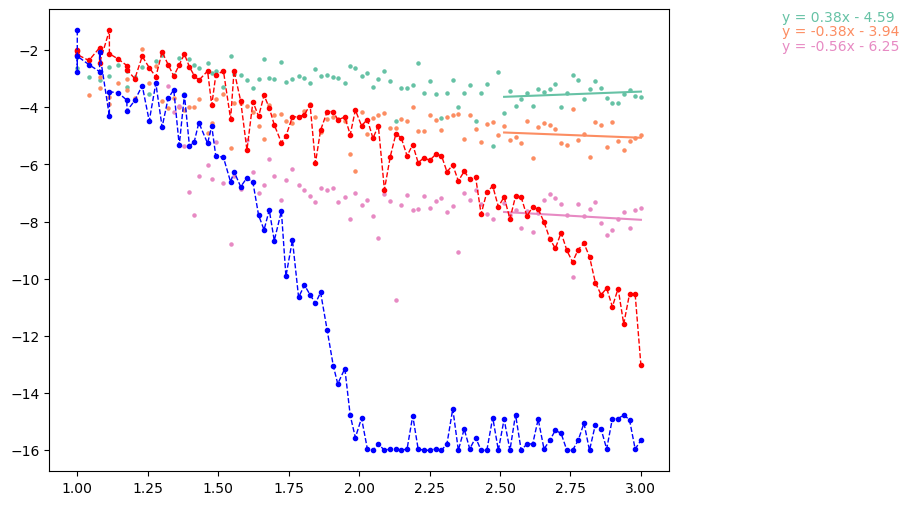

In [3]:
multiple_loglog_graph(nb_samples, IS_MCLS_estims, ref_value, trials_n)

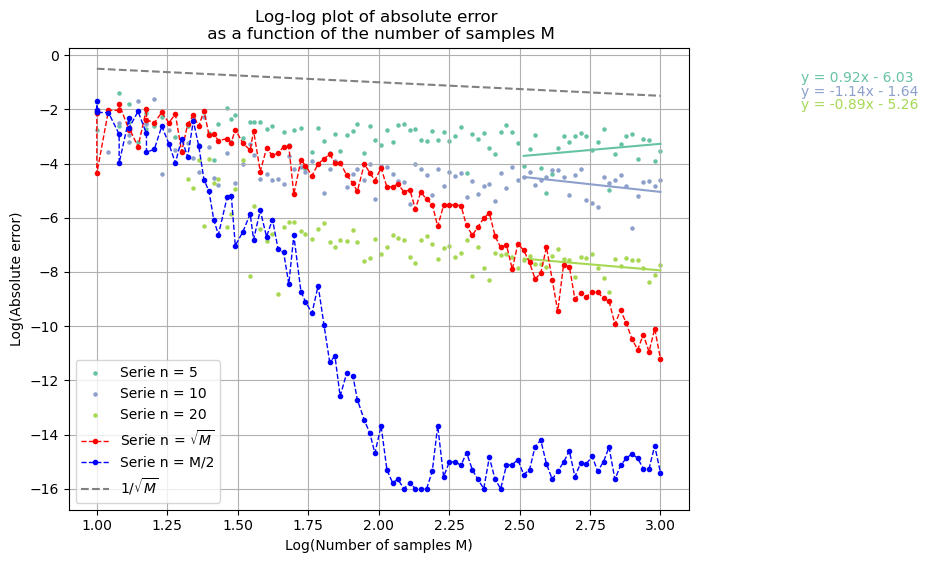

In [11]:
multiple_loglog_graph(nb_samples, IS_MCLS_prime_estims, ref_value, trials_n)

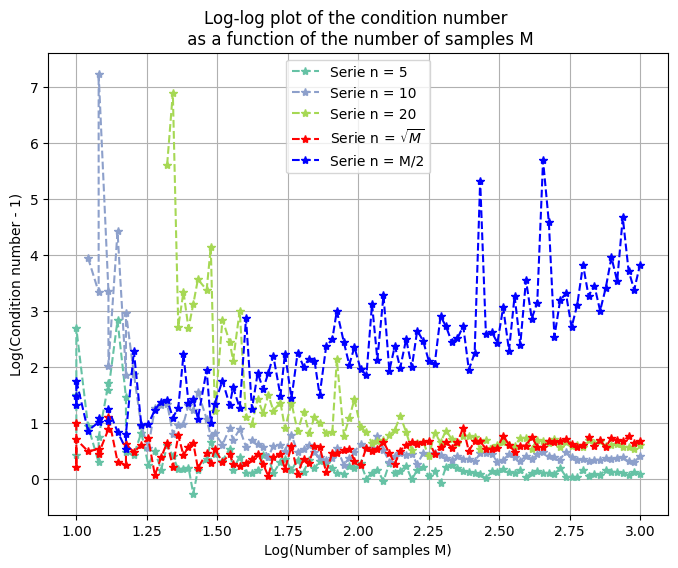

In [12]:
multiple_cond_loglog_graph(nb_samples, IS_MCLS_cond, trials_n)

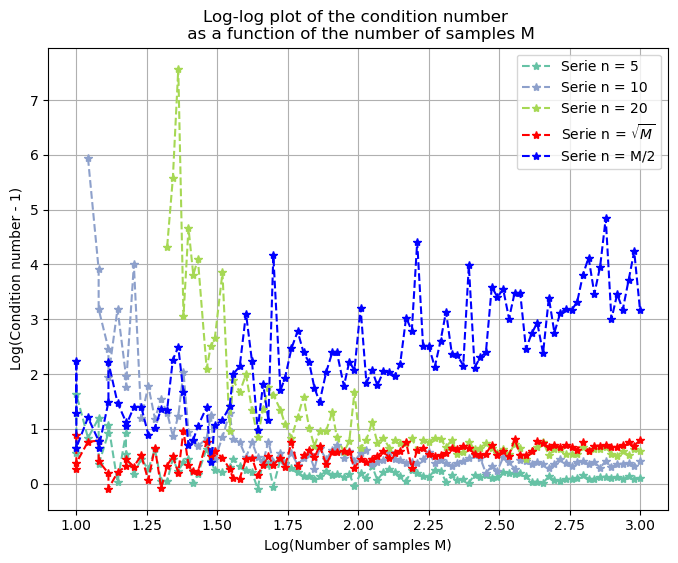

In [12]:
multiple_cond_loglog_graph(nb_samples, IS_MCLS_prime_cond, trials_n)

### Question 5
- Implementation of the above methods to the FitzHugh-Nagumo system of ODEs.


In [2]:
epsilon = 0.08
I = 1.0
v0 = 0
w0 = 0
t0 = 0
T = 10
Nt = 1000
# a and b are uniformly distributed random parameters
a = np.random.uniform(0.6, 0.8)
b = np.random.uniform(0.7, 0.9)

v, w, t = solve_FHN(epsilon, I, v0, w0, t0, T, Nt, a, b)
v_scipy, w_scipy, t_scipy = solve_FHN_scipy(epsilon, I, v0, w0, t0, T, Nt, a, b)

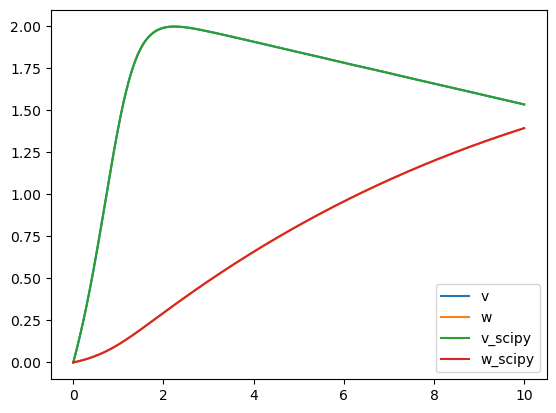

In [52]:
plt.plot(t, v)
plt.plot(t, w)
plt.plot(t_scipy, v_scipy)
plt.plot(t_scipy, w_scipy)
plt.legend(['v', 'w', 'v_scipy', 'w_scipy'])
plt.show()

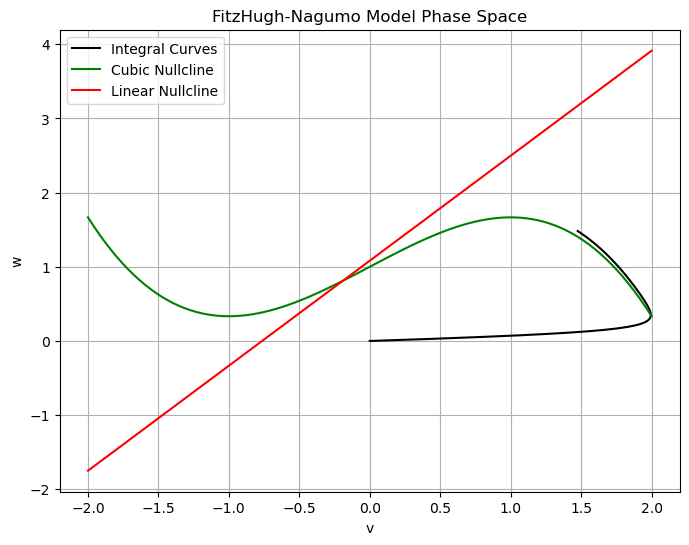

In [24]:
# Plot the phase space
plt.figure(figsize=(8, 6))

# Plot the integral curves 
plt.plot(v, w, 'k-', label='Integral Curves')

# Plot the cubic nullcline 
v_values = np.linspace(-2, 2, 100)
w_values_cubic = v_values - v_values**3 / 3 + I
plt.plot(v_values, w_values_cubic, 'g-', label='Cubic Nullcline')

# Plot the linear nullcline 
w_values_linear = (v_values + a) / b
plt.plot(v_values, w_values_linear, 'r-', label='Linear Nullcline')

# Set labels and title
plt.xlabel('v')
plt.ylabel('w')
plt.title('FitzHugh-Nagumo Model Phase Space')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

#### Question 5.b

In [3]:
# Compute a reference value by using CMC with a high number of sample points

N = int(1e5)
a_unif = np.random.uniform(0.6, 0.8, N)
b_unif = np.random.uniform(0.7, 0.9, N)
ref_value_2D = crude_MC_2D(a_unif, b_unif, epsilon, I, v0, w0, t0, T, Nt)
print(ref_value_2D)

NameError: name 'epsilon' is not defined

In [3]:
# REFERENCE VALUE
ref_value_2D = 1.174996467515269

In [5]:
N = 100
nb_samples = np.logspace(np.log10(10), np.log10(5000), num=N, dtype=int) # evenly spaced values on a logarithmic scale

CMC_estims = np.zeros(N)

for M in range(N):
    a_samples = np.random.uniform(0.6, 0.8, nb_samples[M])
    b_samples = np.random.uniform(0.7, 0.9, nb_samples[M])
    CMC_estims[M] = crude_MC_2D(a_samples, b_samples, epsilon, I, v0, w0, t0, T, Nt)

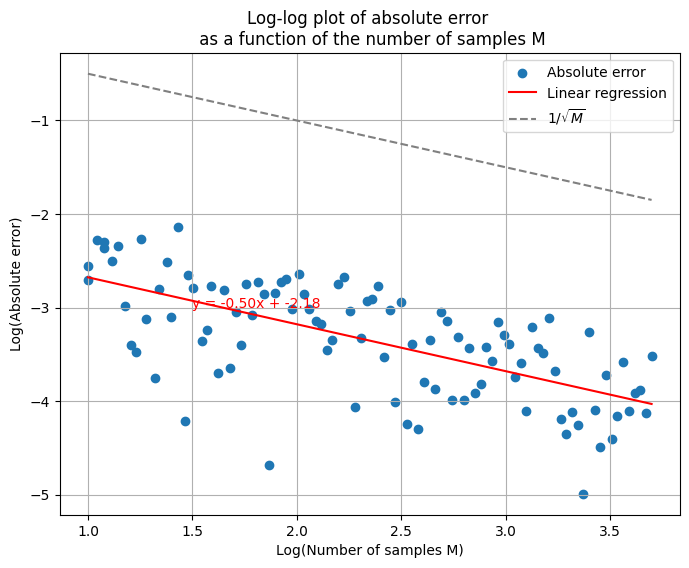

In [7]:
loglog_graph(nb_samples, CMC_estims, ref_value_2D)

In [10]:
N = int(1e4)
n = 3
a_unif = np.random.uniform(0.6, 0.8, N)
b_unif = np.random.uniform(0.7, 0.9, N)
ref_value_2D_MCLS, _, _ = MCLS_2D(a_unif, b_unif, n, epsilon, I, v0, w0, t0, T, Nt)
ref_value_2D_MCLS_prime, _ = MCLS_prime_2D(a_unif, b_unif, n, epsilon, I, v0, w0, t0, T, Nt)
print(ref_value_2D_MCLS)
print(ref_value_2D_MCLS_prime)

1.1749791860591807
1.174979186071431


In [3]:
# Reference values

ref_value_2D_MCLS = 1.1749791860591807
ref_value_2D_MCLS_prime = 1.174979186071431

In [13]:
# MCLS
N = 100
nb_samples = np.logspace(np.log10(10), np.log10(1000), num=N, dtype=int) # evenly spaced values on a logarithmic scale
I_MCLS_2D=np.zeros(N)
cond_MCLS_2D=np.zeros(N)
I_MCLS_prime_2D=np.zeros(N)
cond_MCLS_prime_2D=np.zeros(N)
CI_2D=np.zeros((N, 2))
err_2D=np.zeros(N)
n = 3
alpha=0.05
for M in range(N):
    a_unif = np.random.uniform(0.6, 0.8, nb_samples[M])
    b_unif = np.random.uniform(0.7, 0.9, nb_samples[M])
    I_MCLS_2D[M], cond_MCLS_2D[M], CI_2D[M] = MCLS_2D(a_unif, b_unif, n, epsilon, I, v0, w0, t0, T, Nt)
    I_MCLS_prime_2D[M], cond_MCLS_prime_2D[M] = MCLS_prime_2D(a_unif, b_unif, n, epsilon, I, v0, w0, t0, T, Nt)


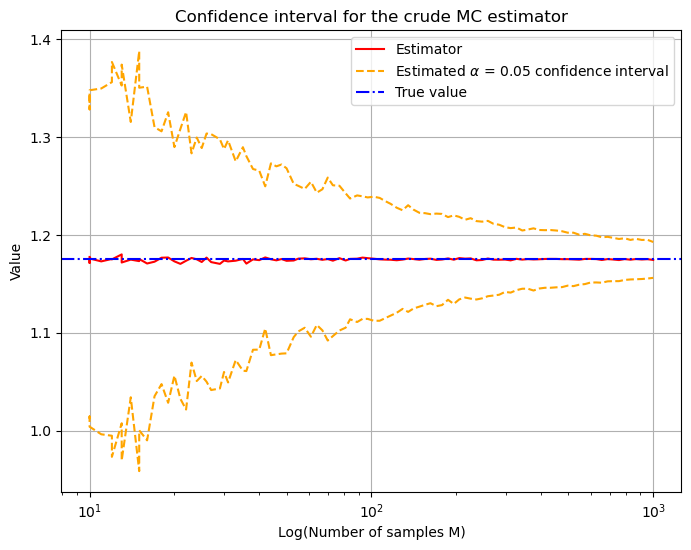

In [7]:
# confidence interval
cut=0
plot_CI(nb_samples[cut:], I_MCLS_2D[cut:], CI_2D[cut:], ref_value_2D_MCLS, alpha)


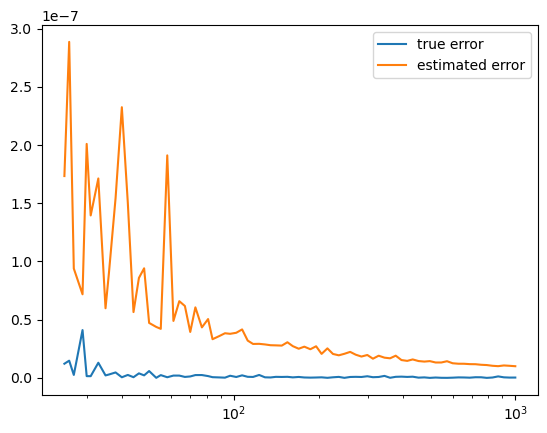

In [15]:

plt.plot(nb_samples[20:], np.abs(I_MCLS_2D-ref_value_2D_MCLS)[20:])
plt.plot(nb_samples[20:], err_2D[20:])
plt.xscale('log')
plt.legend(['true error', 'estimated error'])

In [13]:
N = 50
nb_samples = np.logspace(np.log10(10), np.log10(1000), num=N, dtype=int) # evenly spaced values on a logarithmic scale

trials_n = [0, 1, 2, 3]
#trials_n = [3]
nb_trials_n = len(trials_n)

# MCLS estimators
MCLS_estims_2D = [-1 * np.ones(N) for _ in range(nb_trials_n)]
MCLS_prime_estims_2D = [-1 * np.ones(N) for _ in range(nb_trials_n)]

# confidence interval
#CI_2D = [-1 * np.ones((N, 2)) for _ in range(nb_trials_n)]

# condition number of the Vandermonde matrix
MCLS_cond_2D = [-1 * np.ones(N) for _ in range(nb_trials_n)]
MCLS_prime_cond_2D = [-1 * np.ones(N) for _ in range(nb_trials_n)]

tic = time.time()

for M in range(N):
    for i in range(nb_trials_n):

        if (M * nb_trials_n + i) % 10 == 0:
            print(f'Iteration {M * nb_trials_n + i} of {N * nb_trials_n}')
        
        n = trials_n[i]

        if n < nb_samples[M]:
            a_unif_samps = np.random.uniform(0.6, 0.8, nb_samples[M])
            b_unif_samps = np.random.uniform(0.7, 0.9, nb_samples[M])
            MCLS_estims_2D[i][M], MCLS_cond_2D[i][M] = MCLS_2D(a_unif_samps, b_unif_samps, n, epsilon, I, v0, w0, t0, T, Nt)
            #CI_2D[i][M] = CI_MCLS_2D(a_unif, b_unif, n, epsilon, I, v0, w0, t0, T, Nt, I_MCLS_2D[i][M], alpha)
            MCLS_prime_estims_2D[i][M], MCLS_prime_cond_2D[i][M] = MCLS_prime_2D(a_unif_samps, b_unif_samps, n, epsilon, I, v0, w0, t0, T, Nt)

toc = time.time()
print(f'Elapsed time: {toc - tic}s')

Iteration 0 of 200
Iteration 10 of 200
Iteration 20 of 200
Iteration 30 of 200
Iteration 40 of 200
Iteration 50 of 200
Iteration 60 of 200
Iteration 70 of 200
Iteration 80 of 200
Iteration 90 of 200
Iteration 100 of 200
Iteration 110 of 200
Iteration 120 of 200
Iteration 130 of 200
Iteration 140 of 200
Iteration 150 of 200
Iteration 160 of 200
Iteration 170 of 200
Iteration 180 of 200
Iteration 190 of 200
Elapsed time: 617.0097224712372s


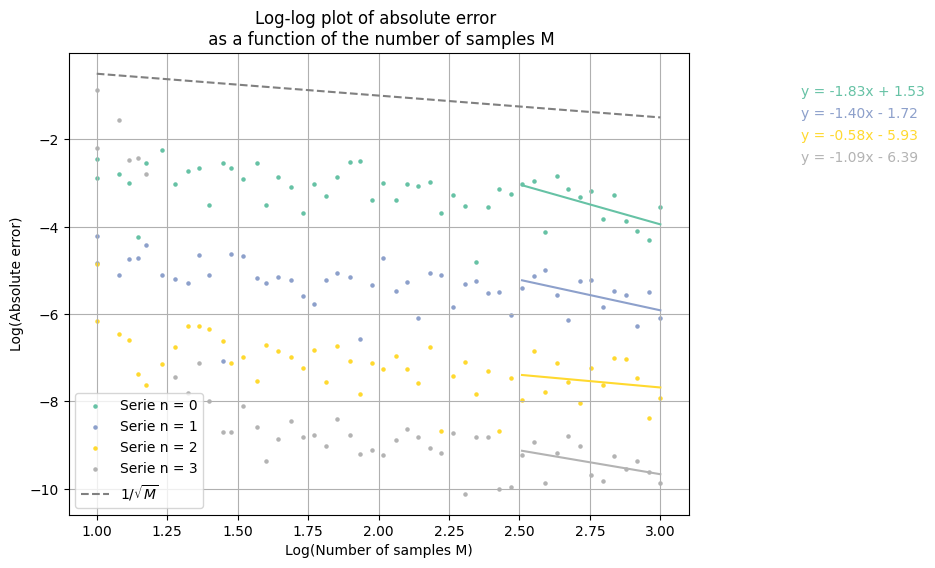

In [14]:
multiple_loglog_graph(nb_samples, MCLS_estims_2D, ref_value_2D_MCLS, trials_n)

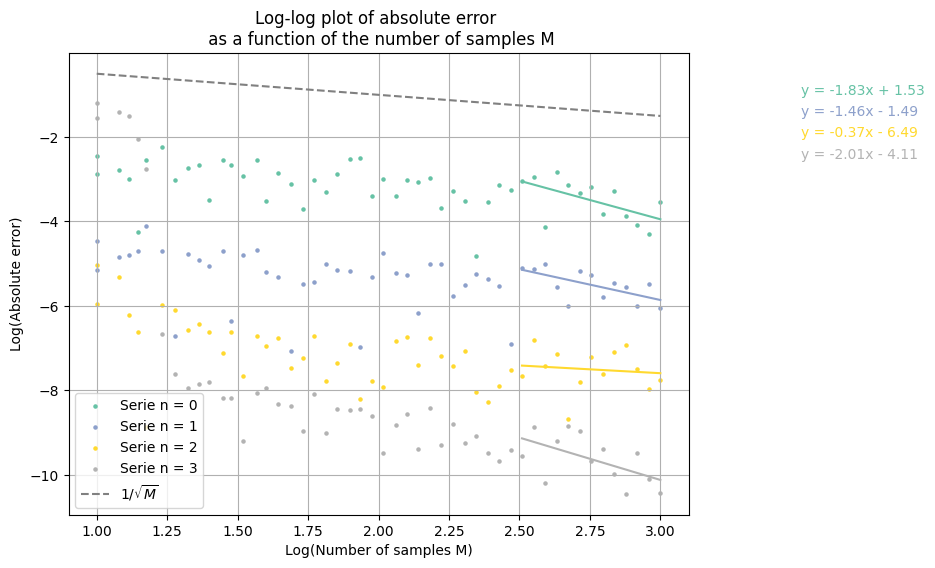

In [15]:
multiple_loglog_graph(nb_samples, MCLS_prime_estims_2D, ref_value_2D_MCLS_prime, trials_n)

/mnt/c/Users/frabe/Desktop/EPFL/1st-semester/stochastic-simulation/Project/Stochastic-simulations-project/question2.py:407: RuntimeWarning: divide by zero encountered in log10
  log_cond = np.log10(cond_filtered - 1)


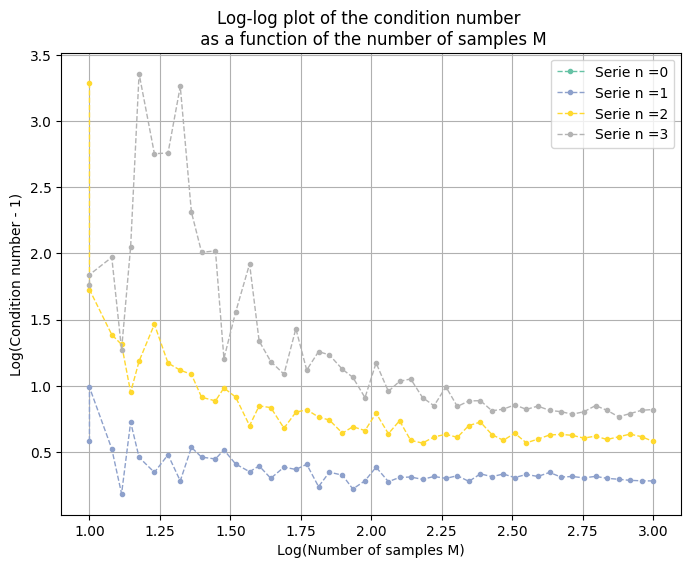

In [16]:
multiple_cond_loglog_graph(nb_samples, MCLS_cond_2D, trials_n)

In [49]:
ls_test_1D(3, 10)

In [50]:
ls_test_2D(7, 100)

In [2]:
# Test the 2D estimators on a simple integral

ref_value_2D = ((1/5) * np.arctan(5)) ** 2
M = 1000
n = 5
a_samples = np.random.uniform(0, 1, M)
b_samples = np.random.uniform(0, 1, M)
I, _ = MCLS_2D_test(a_samples, b_samples, ff, n)
I_prime, _ = MCLS_prime_2D_test(a_samples, b_samples, ff, n)
print(ref_value_2D, I, I_prime)

0.07544918666580633 0.07543206503362078 0.07547870795105491


In [11]:
N = 100
nb_samples = np.logspace(np.log10(10), np.log10(5000), num=N, dtype=int) # evenly spaced values on a logarithmic scale

trials_n = [0, 1, 2, 3, 10]
#trials_n = [5, 10, 15, 20]
nb_trials_n = len(trials_n)

# MCLS estimators
MCLS_estims_2D = [-1 * np.ones(N) for _ in range(nb_trials_n)]
MCLS_prime_estims_2D = [-1 * np.ones(N) for _ in range(nb_trials_n)]

# condition number of the Vandermonde matrix
MCLS_cond_2D = [-1 * np.ones(N) for _ in range(nb_trials_n)]
MCLS_prime_cond_2D = [-1 * np.ones(N) for _ in range(nb_trials_n)]

tic = time.time()

for M in range(N):
    for i in range(nb_trials_n):

        if (M * nb_trials_n + i) % 10 == 0:
            print(f'Iteration {M * nb_trials_n + i} of {N * nb_trials_n}')
        
        n = trials_n[i]

        if n < nb_samples[M]:
            a_unif_samps = np.random.uniform(0, 1, nb_samples[M])
            b_unif_samps = np.random.uniform(0, 1, nb_samples[M])
            MCLS_estims_2D[i][M], MCLS_cond_2D[i][M] = MCLS_2D_test(a_unif_samps, b_unif_samps, ff, n)
            MCLS_prime_estims_2D[i][M], MCLS_prime_cond_2D[i][M] = MCLS_prime_2D_test(a_unif_samps, b_unif_samps, ff, n)

toc = time.time()
print(f'Elapsed time: {toc - tic}s')

Iteration 0 of 500
Iteration 10 of 500
Iteration 20 of 500
Iteration 30 of 500
Iteration 40 of 500
Iteration 50 of 500
Iteration 60 of 500
Iteration 70 of 500
Iteration 80 of 500
Iteration 90 of 500
Iteration 100 of 500
Iteration 110 of 500
Iteration 120 of 500
Iteration 130 of 500
Iteration 140 of 500
Iteration 150 of 500
Iteration 160 of 500
Iteration 170 of 500
Iteration 180 of 500
Iteration 190 of 500
Iteration 200 of 500
Iteration 210 of 500
Iteration 220 of 500
Iteration 230 of 500
Iteration 240 of 500
Iteration 250 of 500
Iteration 260 of 500
Iteration 270 of 500
Iteration 280 of 500
Iteration 290 of 500
Iteration 300 of 500
Iteration 310 of 500
Iteration 320 of 500
Iteration 330 of 500
Iteration 340 of 500
Iteration 350 of 500
Iteration 360 of 500
Iteration 370 of 500
Iteration 380 of 500
Iteration 390 of 500
Iteration 400 of 500
Iteration 410 of 500
Iteration 420 of 500
Iteration 430 of 500
Iteration 440 of 500
Iteration 450 of 500
Iteration 460 of 500
Iteration 470 of 500
Ite

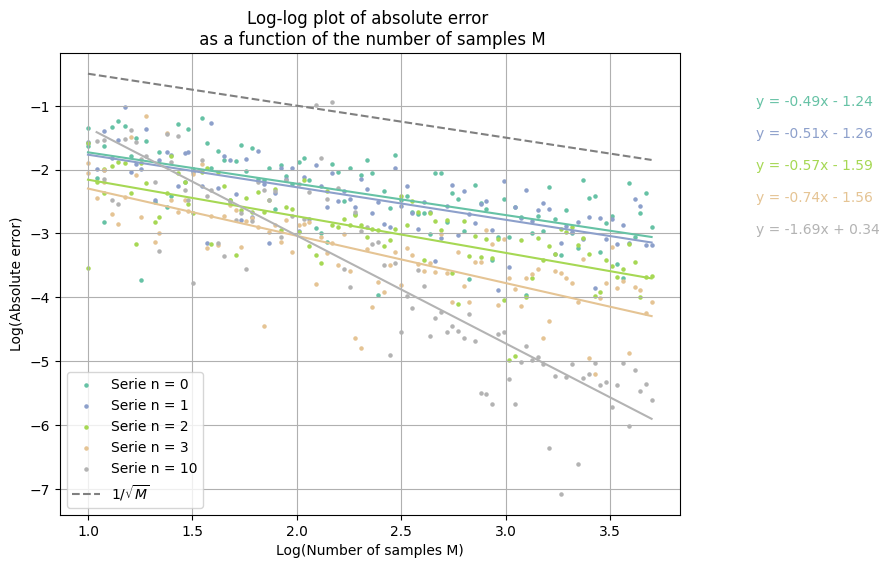

In [12]:
multiple_loglog_graph(nb_samples, MCLS_estims_2D, ref_value_2D, trials_n)

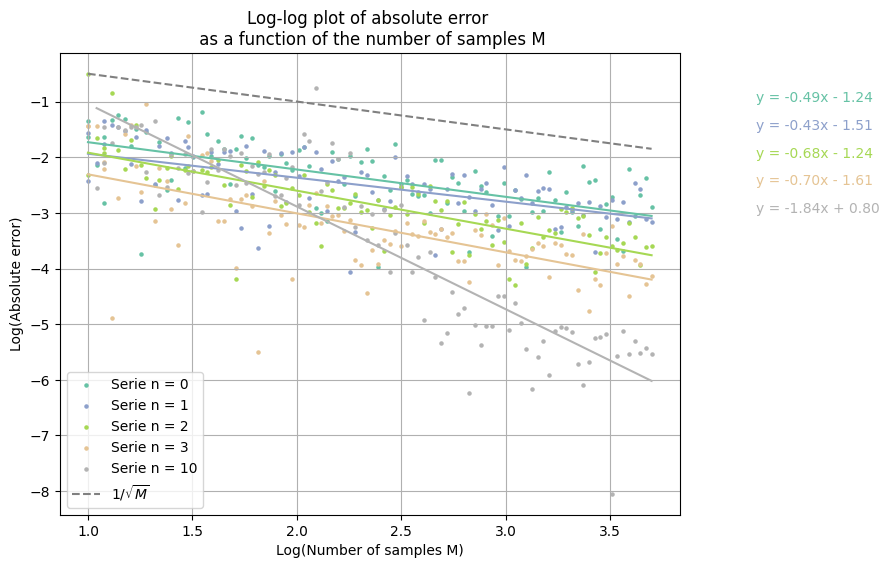

In [13]:
multiple_loglog_graph(nb_samples, MCLS_prime_estims_2D, ref_value_2D, trials_n)

/mnt/c/Users/frabe/Desktop/EPFL/1st-semester/stochastic-simulation/Project/Stochastic-simulations-project/question2.py:326: RuntimeWarning: divide by zero encountered in log10
  log_cond = np.log10(cond_filtered - 1)


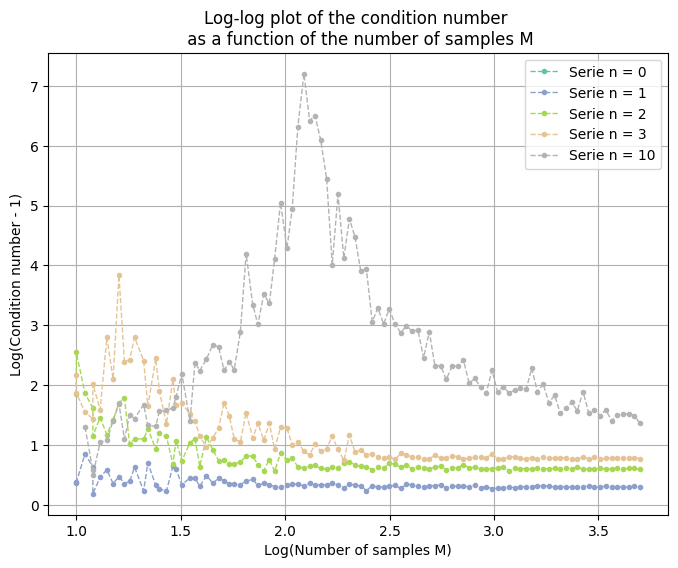

In [14]:
multiple_cond_loglog_graph(nb_samples, MCLS_cond_2D, trials_n)